In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/M_citrusO-20240412T050641Z-001.zip

Archive:  /content/drive/MyDrive/M_citrusO-20240412T050641Z-001.zip
  inflating: M_citrusO/original/g (97).png  
  inflating: M_citrusO/original/g (63).png  
  inflating: M_citrusO/original/g (99).png  
  inflating: M_citrusO/original/g (98).png  
  inflating: M_citrusO/original/g (96).png  
  inflating: M_citrusO/original/g (7).png  
  inflating: M_citrusO/original/g (66).png  
  inflating: M_citrusO/original/g (80).png  
  inflating: M_citrusO/original/g (4).png  
  inflating: M_citrusO/original/g (60).png  
  inflating: M_citrusO/original/g (67).png  
  inflating: M_citrusO/original/g (88).png  
  inflating: M_citrusO/original/g (82).png  
  inflating: M_citrusO/original/g (65).png  
  inflating: M_citrusO/original/g (37).png  
  inflating: M_citrusO/original/g (73).png  
  inflating: M_citrusO/original/g (39).png  
  inflating: M_citrusO/original/g (64).png  
  inflating: M_citrusO/original/g (86).png  
  inflating: M_citrusO/original/g (69).png  
  inflating: M_citrusO/original/g 

In [ ]:
import os
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,UpSampling2D
import cv2
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Define the directory paths
image_source_dir = "/content/M_citrusO/original"
mask_source_dir = "/content/M_citrusO/mask"
overlayed_images_dir = "/content/M_citrusO/overlay"  # Directory with overlayed images

# Destination directories for train and val
train_image_dir = "/content/M_citrusO/legion/image/img"
train_mask_dir = "/content/M_citrusO/legionm/mask/img"
train_overlayed_dir = "/content/M_citrusO/legion/overlayed/img"  # Directory for overlayed train images
test_overlayed_dir = "/content/M_citrusO/legiont/overlayed/img"
test_image_dir = "/content/M_citrusO/legiont/image/img"

# Create train and val directories for overlayed images
os.makedirs(train_overlayed_dir, exist_ok=True)
os.makedirs(test_overlayed_dir, exist_ok=True)
# Create train and val directories
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

# List all image, mask, and overlayed image files
image_files = os.listdir(image_source_dir)
mask_files = os.listdir(mask_source_dir)
overlayed_image_files = os.listdir(overlayed_images_dir)

# Set the proportion of data to be used for validation
validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files) - num_validation_samples

# Randomly shuffle the list of files
random.shuffle(image_files)

# # Move files to train and val directories
# for i, image_file in enumerate(image_files):
#     # Copy the original image and mask to the train directories
#     source_image_path = os.path.join(image_source_dir, image_file)
#     source_mask_file = os.path.splitext(image_file)[0] + ".png"
#     source_mask_path = os.path.join(mask_source_dir, source_mask_file)
#     source_overlayed_path = os.path.join(overlayed_images_dir, image_file)  # Path to the overlayed image

#     shutil.copy(source_image_path, os.path.join(train_image_dir, image_file))
#     shutil.copy(source_mask_path, os.path.join(train_mask_dir, source_mask_file))
#     shutil.copy(source_overlayed_path, os.path.join(train_overlayed_dir, image_file))  # Copy overlayed image
# for i, image_file in enumerate(image_files):
#     # Copy the original image to the test directory
#     source_image_path = os.path.join(image_source_dir, image_file)
#     shutil.copy(source_image_path, os.path.join(test_image_dir, image_file))

#     source_overlayed_path = os.path.join(overlayed_images_dir, image_file)
#     shutil.copy(source_image_path, os.path.join(test_overlayed_dir, image_file))
print("Data separation complete. Overlayed images added to training directory.")

Data separation complete. Overlayed images added to training directory.


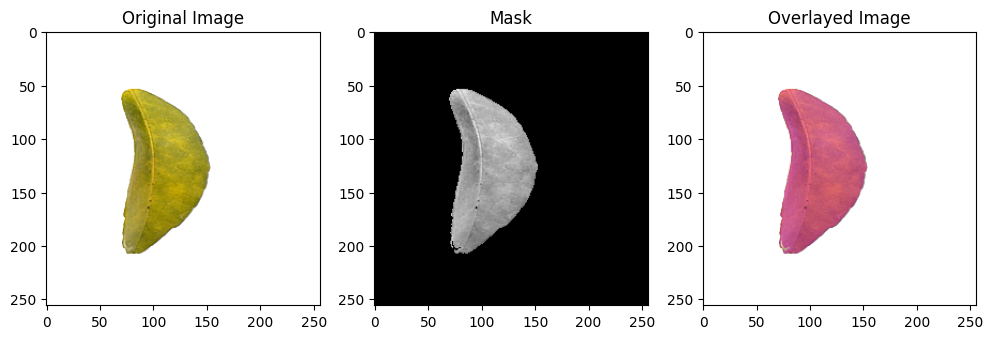

----------------------------------------------------


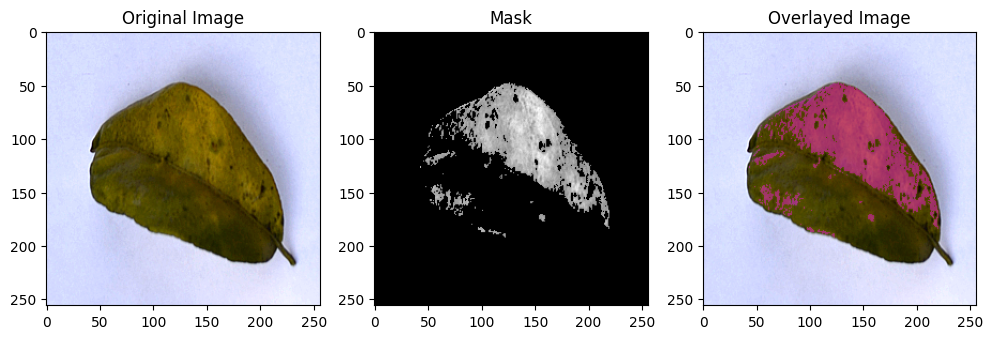

----------------------------------------------------


In [ ]:
def show_images(loops=1):
    for i in range(loops):
        # Paths for the original image, mask, and overlayed image
        img_path = os.path.join(train_image_dir, image_files[i])
        source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
        mask_path = os.path.join(train_mask_dir, source_mask_file)
        overlayed_path = os.path.join(train_overlayed_dir, image_files[i])  # Path to the overlayed image

        # Open the original image, mask, and overlayed image
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        overlayed_img = Image.open(overlayed_path)

        # Display the original image
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')

        # Display the mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')

        # Display the overlayed image
        plt.subplot(1, 3, 3)
        plt.imshow(overlayed_img)
        plt.title('Overlayed Image')
        plt.show()

        print("----------------------------------------------------")
show_images(2)

In [ ]:
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
# Assuming 'num_train_samples', 'train_image_dir', 'train_mask_dir', 'train_overlayed_dir', and 'image_files' are defined
X_train_overlayed = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Resizing training images, masks, and overlayed images')
for i in tqdm(range(num_train_samples), desc='Processing images'):
    # Paths for the original image, mask, and overlayed image
    img_path = os.path.join(train_image_dir, image_files[i])
    source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
    mask_path = os.path.join(train_mask_dir, source_mask_file)
    overlayed_path = os.path.join(train_overlayed_dir, image_files[i])  # Path to the overlayed image

    # Read and resize the original image
    img = Image.open(img_path)
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    # Read and resize the mask
    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[i] = mask

    # Read and resize the overlayed image
    overlayed_img = Image.open(overlayed_path)
    overlayed_img = np.array(overlayed_img)
    overlayed_img = resize(overlayed_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train_overlayed[i] = overlayed_img

# Assuming 'num_validation_samples', 'test_image_dir', and 'image_files' are defined for the validation set
X_test_overlayed = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
X_test = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images and overlayed images')
for i in tqdm(range(num_validation_samples), desc='Processing images'):
    # Paths for the test image and overlayed image
    img_path = os.path.join(test_image_dir, image_files[i])
    overlayed_path = os.path.join(test_overlayed_dir, image_files[i])  # Path to the overlayed image

    # Read and resize the test image
    img = Image.open(img_path)
    img = np.array(img)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    # Read and resize the overlayed image
    overlayed_img = Image.open(overlayed_path)
    overlayed_img = np.array(overlayed_img)
    overlayed_img = resize(overlayed_img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test_overlayed[i] = overlayed_img


inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

Resizing training images, masks, and overlayed images


Processing images: 100%|██████████| 413/413 [00:08<00:00, 48.76it/s]


Resizing test images and overlayed images


Processing images: 100%|██████████| 103/103 [00:02<00:00, 40.77it/s]


In [ ]:
# Load your datasets
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Function to load images into arrays
def load_images_from_directory(directory, target_size=(128, 128)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)

# Load your datasets
X_train_overlayed = load_images_from_directory(train_overlayed_dir)
Y_train = load_images_from_directory(train_mask_dir, target_size=(128, 128))
X_val = load_images_from_directory(test_image_dir)
Y_val = load_images_from_directory(test_overlayed_dir)

# Make sure that the masks are in a binary format
Y_train = (Y_train > 0).astype(np.uint8)
Y_val = (Y_val > 0).astype(np.uint8)

# Normalize the images
X_train_overlayed = X_train_overlayed / 255.0
X_val = X_val / 255.0

Epoch 1/60
186/186 [==============================] - 9s 19ms/step - loss: 0.2597 - accuracy: 0.9030 - iou: 0.3996 - weighted_mean_iou: 0.4269 - mean_pixel_accuracy: 0.9030 - dice_coefficient: 0.5700 - mean_boundary_f1_score: 0.3461 - val_loss: 0.5981 - val_accuracy: 0.7804 - val_iou: 0.2667 - val_weighted_mean_iou: 0.2865 - val_mean_pixel_accuracy: 0.7804 - val_dice_coefficient: 0.4192 - val_mean_boundary_f1_score: 0.3315
Epoch 2/60
186/186 [==============================] - 2s 9ms/step - loss: 0.2004 - accuracy: 0.9151 - iou: 0.4668 - weighted_mean_iou: 0.4917 - mean_pixel_accuracy: 0.9151 - dice_coefficient: 0.6378 - mean_boundary_f1_score: 0.3460 - val_loss: 0.1988 - val_accuracy: 0.9182 - val_iou: 0.4528 - val_weighted_mean_iou: 0.4801 - val_mean_pixel_accuracy: 0.9182 - val_dice_coefficient: 0.6241 - val_mean_boundary_f1_score: 0.3315
Epoch 3/60
186/186 [==============================] - 2s 9ms/step - loss: 0.1875 - accuracy: 0.9196 - iou: 0.4892 - weighted_mean_iou: 0.5075 - mea

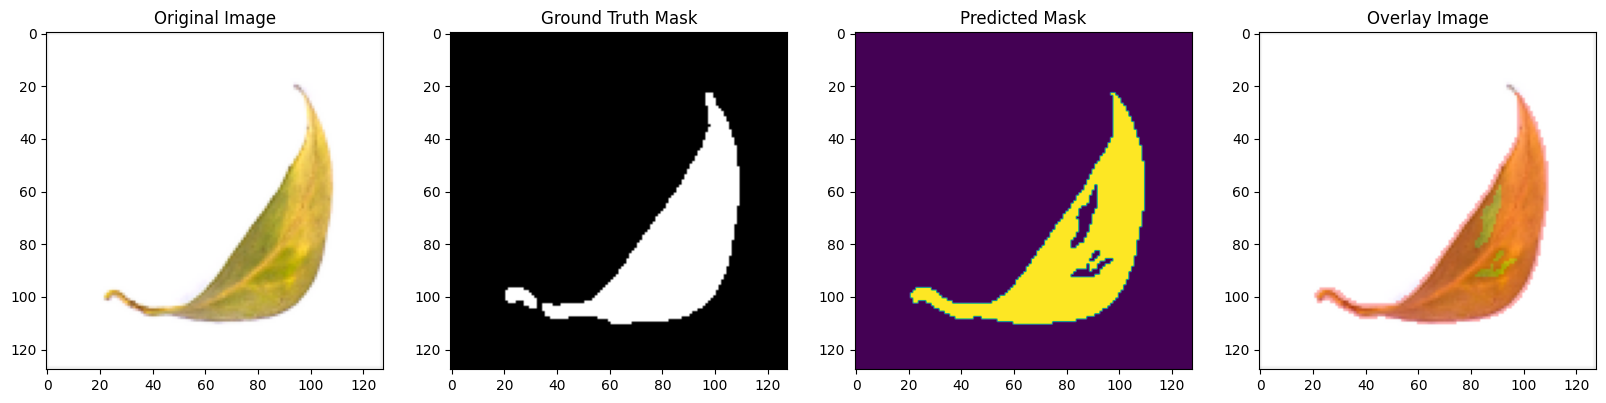

IndexError: index 42 is out of bounds for axis 0 with size 42

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import random

# Define a global variable for the kernel used in conv2d to avoid re-creation
kernel = K.ones((3, 3, 1, 1))

# Define custom metrics
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    return intersection / (union + K.epsilon())

@tf.function
def mean_boundary_f1_score(y_true, y_pred):
    # Use the pre-defined 'kernel' tensor
    y_true_boundary = K.cast(K.greater(K.conv2d(y_true, kernel, strides=(1, 1), padding='same'), 0.01), 'float32')
    y_pred_boundary = K.cast(K.greater(K.conv2d(y_pred, kernel, strides=(1, 1), padding='same'), 0.01), 'float32')
    intersection = K.sum(y_true_boundary * y_pred_boundary)
    precision = intersection / (K.sum(y_pred_boundary) + K.epsilon())
    recall = intersection / (K.sum(y_true_boundary) + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

# Define custom metrics
def weighted_mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = intersection / union
    weights = K.sum(y_true, axis=[1,2,3])
    weighted_iou = K.sum(iou * weights) / K.sum(weights)
    return weighted_iou

def mean_pixel_accuracy(y_true, y_pred):
    correct_pixels = K.sum(K.cast(K.equal(K.round(y_true), K.round(y_pred)), 'float32'), axis=[1,2,3])
    total_pixels = K.prod(K.cast(K.shape(y_true)[1:3], 'float32'))
    return correct_pixels / total_pixels

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define the conv_block function
def conv_block(input_tensor, num_filters, kernel_size=3, activation='relu'):
    x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same',
               kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

# Define the encoder_block function
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

# Define the decoder_block function
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

# Model architecture
inputs = Input(shape=(128, 128, 3))
x1, p1 = encoder_block(inputs, 32)
x1 = LeakyReLU(alpha=0.1)(x1)
x2, p2 = encoder_block(p1, 64)
x2 = LeakyReLU(alpha=0.1)(x2)
b = conv_block(p2, 128)
d2 = decoder_block(b, x2, 64)
d1 = decoder_block(d2, x1, 32)
outputs = Conv2D(1, (1, 1), activation='sigmoid')(d1)
model = Model(inputs=[inputs], outputs=[outputs])

# Compile the model with custom metrics
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',iou, weighted_mean_iou, mean_pixel_accuracy, dice_coefficient, mean_boundary_f1_score])

# Train the model
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=60)

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

def overlay_mask_on_image(image, mask, alpha=0.3):
    # Assuming mask is a color image with the same dimensions as the input image
    # and the mask's positive areas are represented by non-black pixels.

    # Create an overlay mask where the mask is not black
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)

    # Create an RGB version of the binary overlay mask
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    # Overlay the mask on the image
    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
selected_image = X_train[ix]
ground_truth_mask = Y_train[ix]
selected_mask = preds_train_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

# Display the original image, the mask, and the overlay
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(selected_image)
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(np.squeeze(ground_truth_mask), cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(1, 4, 3)
plt.imshow(np.squeeze(selected_mask))
plt.title('Predicted Mask')
plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
selected_image = X_train[int(X_train.shape[0]*0.9):][ix]
ground_truth_mask = np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
selected_mask = preds_val_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

# Display the original image, the mask, and the overlay
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(selected_image)
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(1, 4, 3)
plt.imshow(selected_mask)
plt.title('Predicted Mask')
plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()


In [ ]:
# Calculate pixel area of the original image
original_image_area = selected_image.shape[0] * selected_image.shape[1]

# Calculate pixel area of the overlay image
overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"Pixel area of the original image: {original_image_area}")
print(f"Pixel area of the overlay image: {overlay_image_area}")


Pixel area of the original image: 16384
Pixel area of the overlay image: 2309


4/4 [==============================] - 0s 20ms/step
The leaf area is 3383.0 pixels.


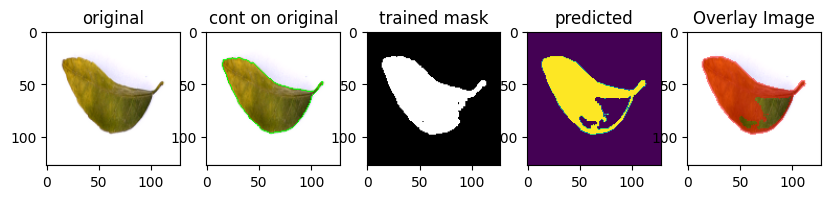

The affected area is 3112 pixels.


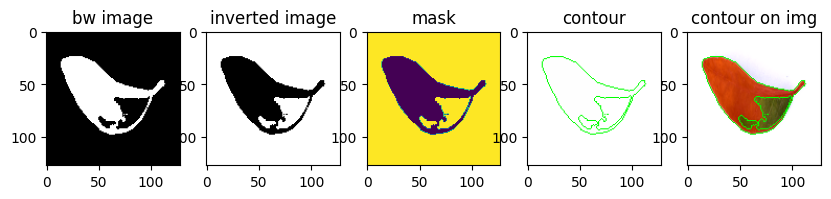

leaf region 4455.5


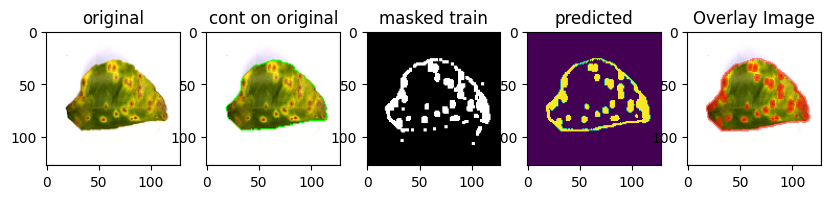

The affected area is 1624 pixels.


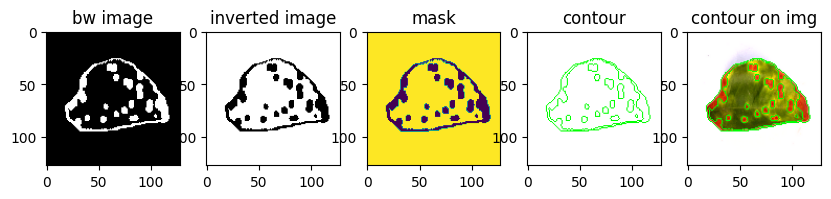

In [ ]:
idx = 7

idx = 5


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

def overlay_mask_on_image(image, mask, alpha=0.5):
    # Assuming mask is a color image with the same dimensions as the input image
    # and the mask's positive areas are represented by non-black pixels.

    # Create an overlay mask where the mask is not black
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)

    # Create an RGB version of the binary overlay mask
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    # Overlay the mask on the image
    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image

# Perform a sanity check on some random training samples111111
ix = random.randint(0, len(preds_train_t))
selected_image = X_train[ix]
im1 = selected_image
ground_truth_mask = Y_train[ix]
selected_mask = preds_train_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('original')
plt.imshow(selected_image)
# Convert the image to grayscale
gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(im1, contours1, -1, (0, 255, 0), 1)

# Calculate the area of each contour
t_area = 0
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    t_area += area

print(f"The leaf area is {t_area} pixels.")
plt.subplot(1,5,2)
plt.title('cont on original')
plt.imshow(im1)

# imshow(np.squeeze(Y_train[ix]))222222train masked image
# data1 = np.squeeze(Y_train[ix])
plt.subplot(1,5,3)
plt.title('trained mask')
plt.imshow(ground_truth_mask,cmap='gray')  # Add cmap='gray' if the image is grayscale

#33333333333333predection of training set
# data = np.squeeze(preds_train_t[ix])
plt.subplot(1,5,4)
plt.title('predicted')
plt.imshow(selected_mask)

plt.subplot(1, 5, 5)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

# Load the image
image = selected_mask

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
# total_area = 0
# # Calculate the area of each contour
# for j, contour in enumerate(contours):
#     area1 = cv2.contourArea(contour)
#     # print(f"Leaf {j+1} area: {area1} pixels")
#     total_area += area1
# Calculate pixel area of the overlay image
overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


#Perform a sanity check on some random validation samples4444441111111-----------------------------------------------------------
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
selected_image = X_train[int(X_train.shape[0]*0.9):][ix]
im = selected_image
ground_truth_mask = np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
selected_mask = preds_val_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

# ix = random.randint(0, len(preds_val_t))
# x2 = X_train[int(X_train.shape[0]*0.9):][ix]
# x1 = X_train[int(X_train.shape[0]*0.9):][ix]
plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('original')
plt.imshow(selected_image)
# Convert the image to grayscale
gray1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(im, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
print(f"leaf region {total_area1}")
plt.subplot(1,5,2)
plt.title('cont on original')
plt.imshow(im)


#555555555555222222222222
# data1 =np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
plt.subplot(1,5,3)
plt.title('masked train')
plt.imshow(ground_truth_mask,cmap= 'gray')


# 666666666666333333333333predict of validation set---------------------------
# data = np.squeeze(preds_val_t[ix])

plt.subplot(1,5,4)
plt.title('predicted')
plt.imshow(selected_mask)

plt.subplot(1, 5, 5)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

# Load the image
image = selected_mask

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')


# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image2 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image2, contours, -1, (0, 255, 0), 1)
# total_area = 0
# # Calculate the area of each contour
# for j, contour in enumerate(contours):
#     area1 = cv2.contourArea(contour)
#     # print(f"Leaf {j+1} area: {area1} pixels")
#     total_area += area1

overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image2)
# Display all subplots
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import random

# Define a global variable for the kernel used in conv2d to avoid re-creation
kernel = K.ones((3, 3, 1, 1))

# Define custom metrics
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

# Define custom metrics
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    return intersection / (union + K.epsilon())

@tf.function
def mean_boundary_f1_score(y_true, y_pred):
    # Use the pre-defined 'kernel' tensor
    y_true_boundary = K.cast(K.greater(K.conv2d(y_true, kernel, strides=(1, 1), padding='same'), 0.01), 'float32')
    y_pred_boundary = K.cast(K.greater(K.conv2d(y_pred, kernel, strides=(1, 1), padding='same'), 0.01), 'float32')
    intersection = K.sum(y_true_boundary * y_pred_boundary)
    precision = intersection / (K.sum(y_pred_boundary) + K.epsilon())
    recall = intersection / (K.sum(y_true_boundary) + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

def mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = intersection / (union + K.epsilon())
    return K.mean(iou)

# Define custom metrics
def weighted_mean_iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = intersection / union
    weights = K.sum(y_true, axis=[1,2,3])
    weighted_iou = K.sum(iou * weights) / K.sum(weights)
    return weighted_iou
def pixel_accuracy(y_true, y_pred):
    correct_pixels = K.sum(K.cast(K.equal(K.round(y_true), K.round(y_pred)), 'float32'), axis=[1,2,3])
    total_pixels = K.prod(K.cast(K.shape(y_true)[1:3], 'float32'))
    return correct_pixels / total_pixels

def mean_pixel_accuracy(y_true, y_pred):
    correct_pixels = K.sum(K.cast(K.equal(K.round(y_true), K.round(y_pred)), 'float32'), axis=[1,2,3])
    total_pixels = K.prod(K.cast(K.shape(y_true)[1:3], 'float32'))
    return correct_pixels / total_pixels

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define the conv_block function
def conv_block(input_tensor, num_filters, kernel_size=3, activation='relu'):
    x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same',
               kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

# Define the encoder_block function
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

# Define the decoder_block function
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

# Model architecture
inputs = Input(shape=(128, 128, 3))
x1, p1 = encoder_block(inputs, 32)
x1 = LeakyReLU(alpha=0.1)(x1)
x2, p2 = encoder_block(p1, 64)
x2 = LeakyReLU(alpha=0.1)(x2)
b = conv_block(p2, 128)
d2 = decoder_block(b, x2, 64)
d1 = decoder_block(d2, x1, 32)
outputs = Conv2D(1, (1, 1), activation='sigmoid')(d1)
model11 = Model(inputs=[inputs], outputs=[outputs])

# Compile the model with custom metrics
# model11.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy',iou, weighted_mean_iou, mean_pixel_accuracy, dice_coefficient, mean_boundary_f1_score])
# Compile the model with the mean_iou metric added
model11.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy',
                metrics=['accuracy', iou,mean_iou, weighted_mean_iou,pixel_accuracy, mean_pixel_accuracy, dice_coefficient, mean_boundary_f1_score, precision, recall, f1_score, specificity])

# Train the model
history = model11.fit(X_train_overlayed, Y_train, validation_split=0.1, batch_size=2, epochs=120)

preds_train = model11.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model11.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model11.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

def overlay_mask_on_image(image, mask, alpha=0.3):
    # Assuming mask is a color image with the same dimensions as the input image
    # and the mask's positive areas are represented by non-black pixels.

    # Create an overlay mask where the mask is not black
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)

    # Create an RGB version of the binary overlay mask
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    # Overlay the mask on the image
    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
selected_image = X_train[ix]
ground_truth_mask = Y_train[ix]
selected_mask = preds_train_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

# Display the original image, the mask, and the overlay
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(selected_image)
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(np.squeeze(ground_truth_mask), cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(1, 4, 3)
plt.imshow(np.squeeze(selected_mask))
plt.title('Predicted Mask')
plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
selected_image = X_train[int(X_train.shape[0]*0.9):][ix]
ground_truth_mask = np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
selected_mask = preds_val_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

# Display the original image, the mask, and the overlay
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(selected_image)
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')
plt.subplot(1, 4, 3)
plt.imshow(selected_mask)
plt.title('Predicted Mask')
plt.subplot(1, 4, 4)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

Epoch 1/120
186/186 [==============================] - 10s 14ms/step - loss: 0.4240 - accuracy: 0.8907 - iou: 0.3468 - mean_iou: 0.3465 - weighted_mean_iou: 0.3854 - pixel_accuracy: 0.8907 - mean_pixel_accuracy: 0.8907 - dice_coefficient: 0.5154 - mean_boundary_f1_score: 0.3480 - precision: 0.7100 - recall: 0.9112 - f1_score: 0.7631 - specificity: 0.8889 - val_loss: 0.2855 - val_accuracy: 0.9529 - val_iou: 0.3588 - val_mean_iou: 0.3588 - val_weighted_mean_iou: 0.4033 - val_pixel_accuracy: 0.9529 - val_mean_pixel_accuracy: 0.9529 - val_dice_coefficient: 0.5264 - val_mean_boundary_f1_score: 0.3212 - val_precision: 0.7912 - val_recall: 0.8695 - val_f1_score: 0.8230 - val_specificity: 0.9646
Epoch 2/120
186/186 [==============================] - 2s 13ms/step - loss: 0.2464 - accuracy: 0.9614 - iou: 0.4292 - mean_iou: 0.4290 - weighted_mean_iou: 0.4731 - pixel_accuracy: 0.9614 - mean_pixel_accuracy: 0.9614 - dice_coefficient: 0.6081 - mean_boundary_f1_score: 0.3484 - precision: 0.8861 - rec

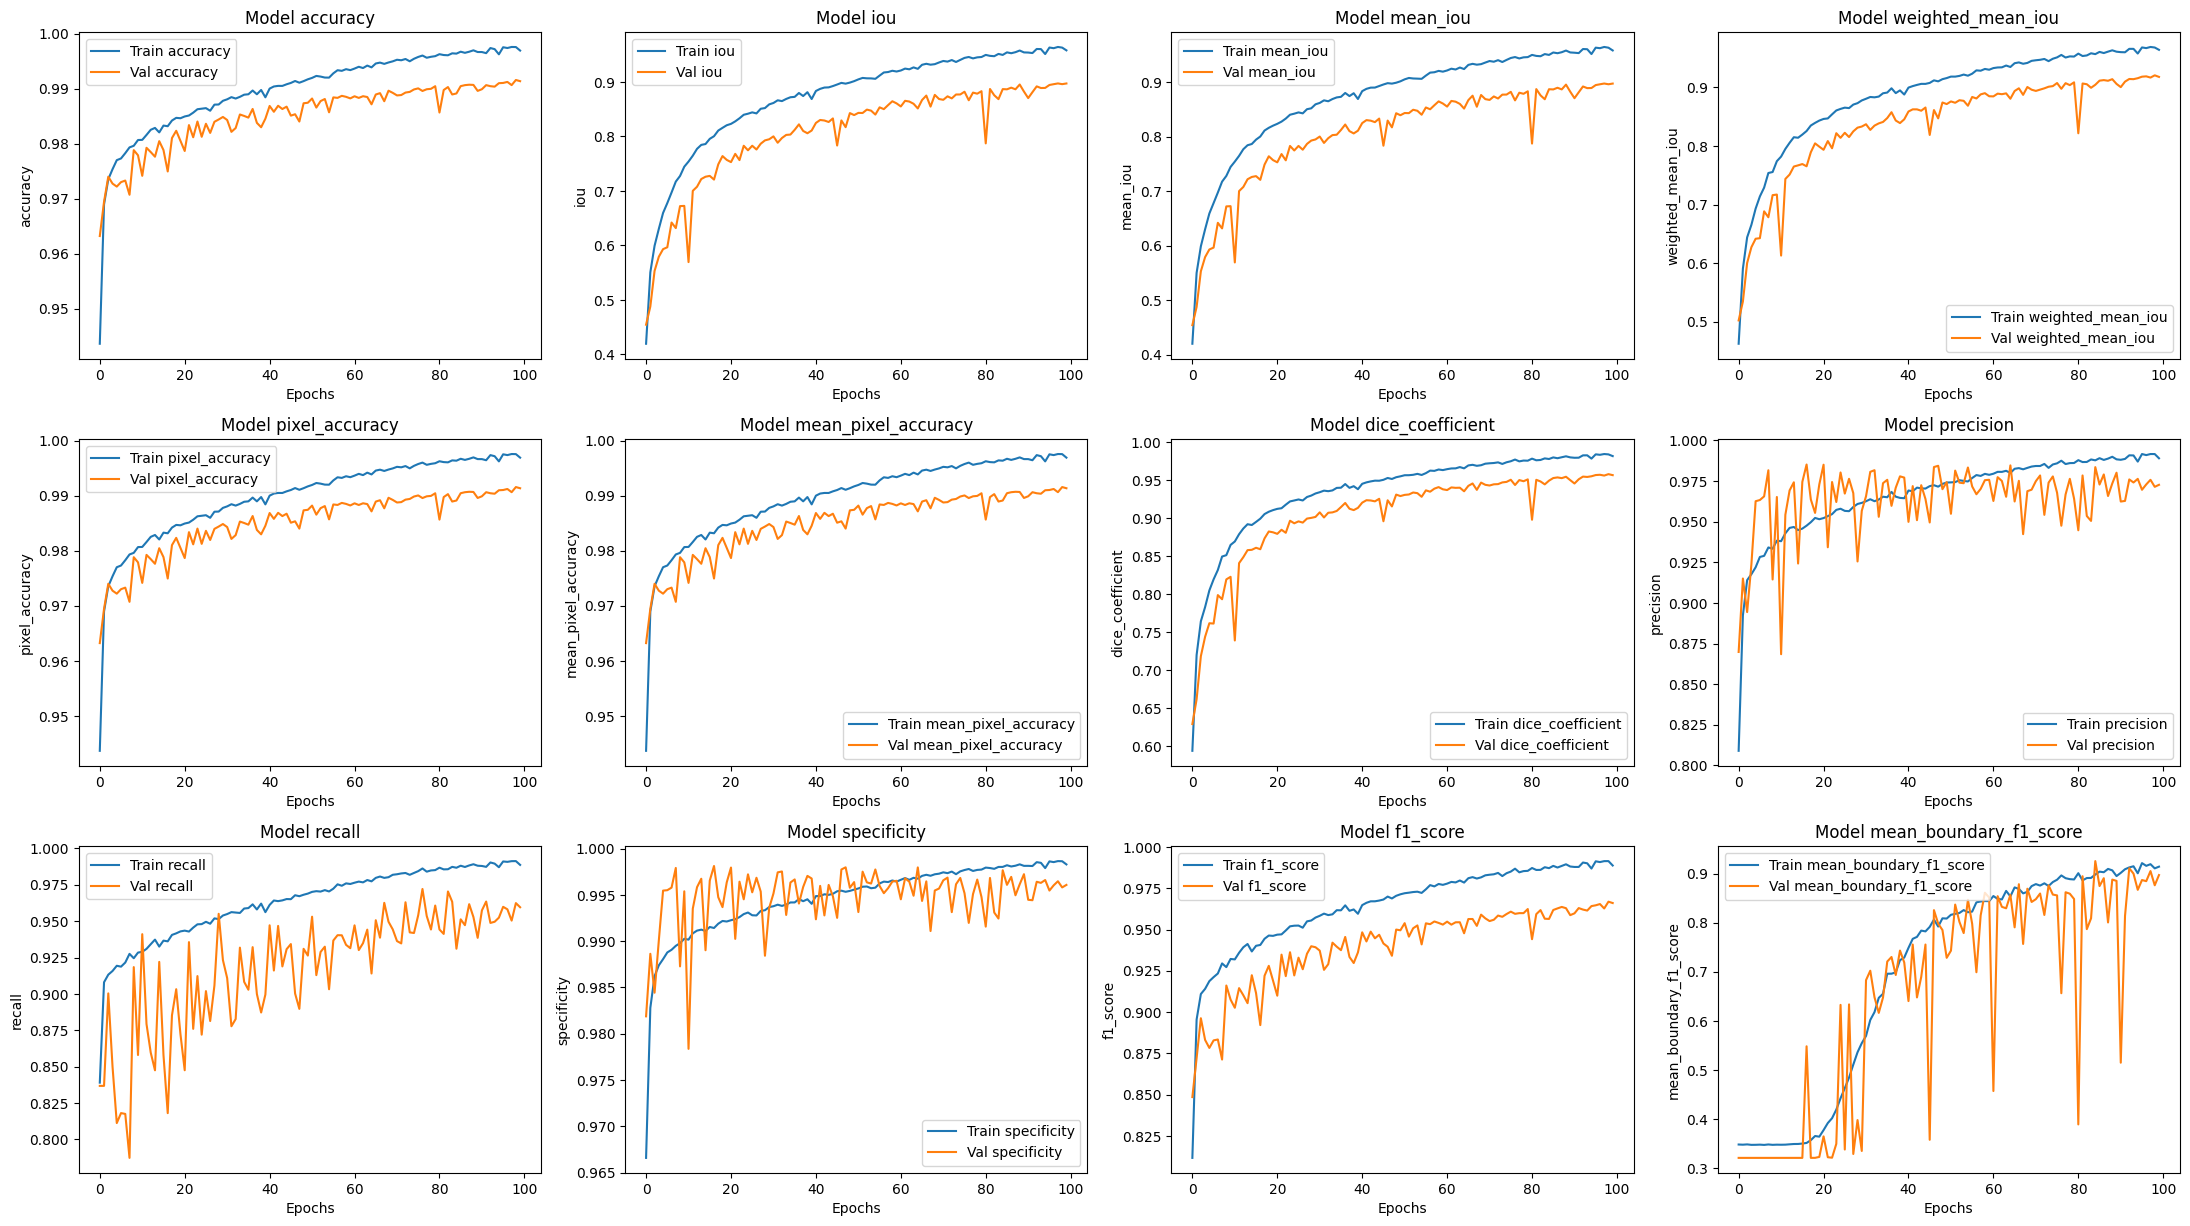

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from the fit function
# metrics = ['accuracy', 'iou', 'weighted_mean_iou', 'mean_pixel_accuracy',
#            'dice_coefficient', 'mean_boundary_f1_score', 'precision', 'recall',
#            'f1_score', 'specificity', 'mean_iou', 'pixel_accuracy']

metrics = ['accuracy','loss', 'iou', 'mean_iou', 'weighted_mean_iou', 'pixel_accuracy', 'mean_pixel_accuracy',
           'dice_coefficient', 'precision', 'recall','specificity',
           'f1_score' ,'mean_boundary_f1_score']
# Plot each metric
plt.figure(figsize=(22, 16))
for i, metric in enumerate(metrics):
    plt.subplot(4, 4, i+1)
    plt.plot(history.history[metric], label='Train ' + metric)
    plt.plot(history.history['val_' + metric], label='Val ' + metric)
    plt.title('Model ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

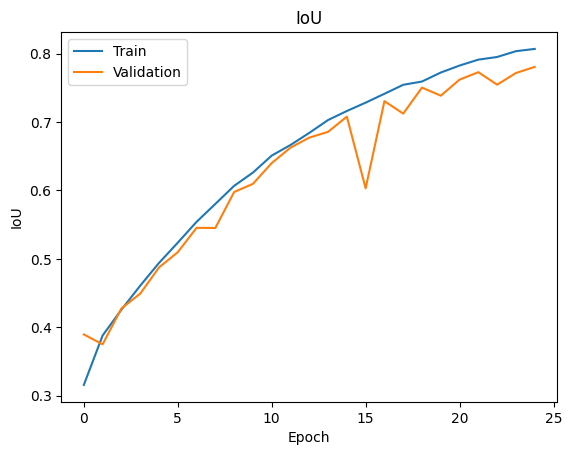

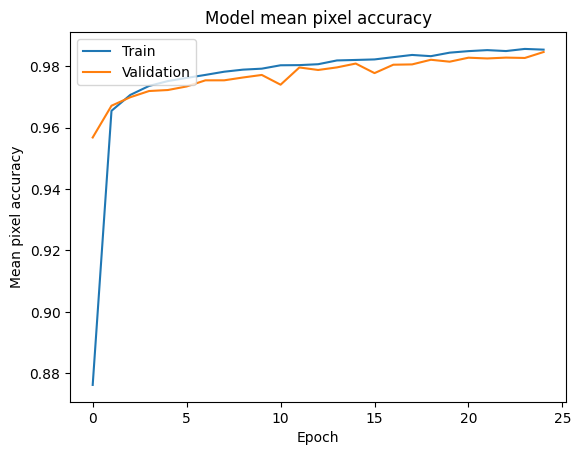

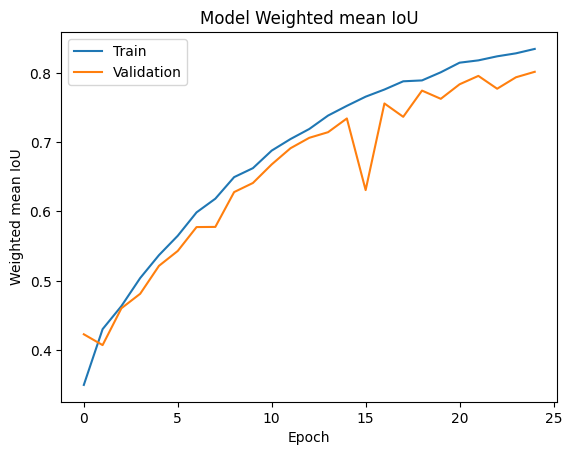

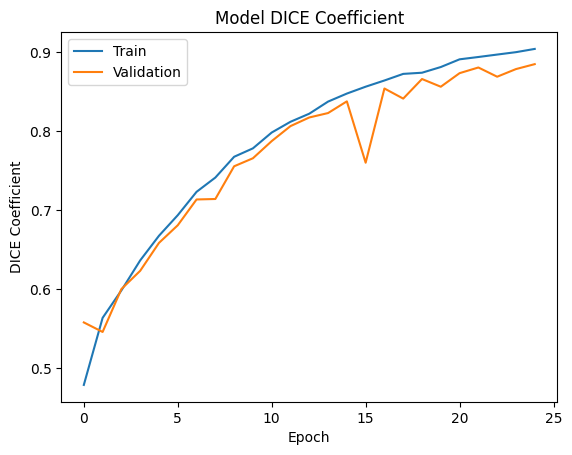

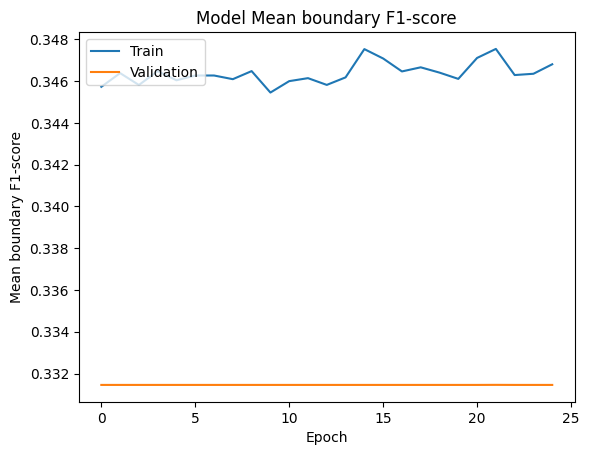

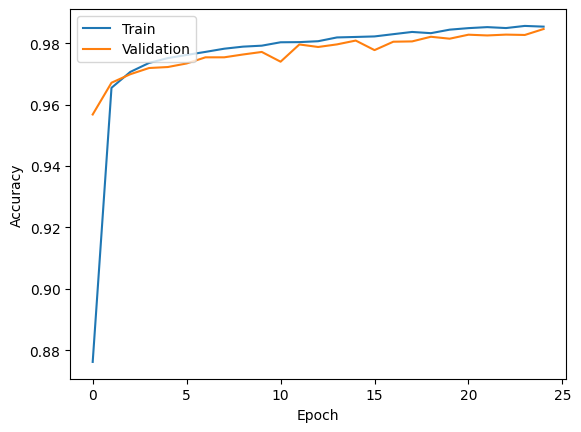

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model.fit() method
# Plot Weighted mean IoU
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot mean pixel accuracy
plt.plot(history.history['mean_pixel_accuracy'])
plt.plot(history.history['val_mean_pixel_accuracy'])
plt.title('Model mean pixel accuracy')
plt.ylabel('Mean pixel accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Weighted mean IoU
plt.plot(history.history['weighted_mean_iou'])
plt.plot(history.history['val_weighted_mean_iou'])
plt.title('Model Weighted mean IoU')
plt.ylabel('Weighted mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot DICE coefficient
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model DICE Coefficient')
plt.ylabel('DICE Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Mean boundary F1-score
plt.plot(history.history['mean_boundary_f1_score'])
plt.plot(history.history['val_mean_boundary_f1_score'])
plt.title('Model Mean boundary F1-score')
plt.ylabel('Mean boundary F1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
unetacc = history.history['accuracy'][-1]

In [ ]:
image_source_dir = "/content/drive/MyDrive/M_citrus (1)/images"
mask_source_dir = "/content/drive/MyDrive/M_citrus (1)/mask"

# Destination directories for train and val
train_image_dir = "/content/drive/MyDrive/M_citrus (1)/legion/image/img"
train_mask_dir = "/content/drive/MyDrive/M_citrus (1)/legionm/mask/img"
test_image_dir = "/content/drive/MyDrive/M_citrus (1)/legiont/image/img"

# Create train and val directories
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

# List all image and mask files
image_files = os.listdir(image_source_dir)
mask_files = os.listdir(mask_source_dir)

# Set the proportion of data to be used for validation
validation_split = 0.2

# Calculate the number of samples for validation
num_validation_samples = int(len(image_files) * validation_split)
num_train_samples = len(image_files)-num_validation_samples

# Randomly shuffle the list of files
random.shuffle(image_files)

# # Move files to train and val directories
# for i, image_file in enumerate(image_files):
#     source_image_path = os.path.join(image_source_dir, image_file)
#     source_mask_file = os.path.splitext(image_file)[0] + ".png"
#     source_mask_path = os.path.join(mask_source_dir, source_mask_file)
#     shutil.copy(source_image_path, os.path.join(train_image_dir, image_file))
#     shutil.copy(source_mask_path, os.path.join(train_mask_dir, source_mask_file))

# random.shuffle(image_files)

# for i, image_file in enumerate(image_files):
#     source_image_path = os.path.join(image_source_dir, image_file)
#     shutil.copy(source_image_path, os.path.join(test_image_dir, image_file))

print("Data separation complete.")

Data separation complete.


In [ ]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


X_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((num_train_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


print('Resizing training images and masks')
for i in tqdm(range(num_train_samples), desc='Processing images'):
    img_path = os.path.join(train_image_dir, image_files[i])
    source_mask_file = os.path.splitext(image_files[i])[0] + ".png"
    mask_path = os.path.join(train_mask_dir, source_mask_file)

    img = Image.open(img_path)
    img = np.array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

    mask = Image.open(mask_path).convert('L')
    mask = np.array(mask)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    Y_train[i] = mask


X_test = np.zeros((num_validation_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')
for i in tqdm(range(num_validation_samples), desc='Processing images'):
    img_path = os.path.join(test_image_dir, image_files[i])
    img = Image.open(img_path)
    img = np.array(img)
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[i] = img

Resizing training images and masks


Processing images: 100%|██████████| 431/431 [00:54<00:00,  7.89it/s]


Resizing test images


Processing images: 100%|██████████| 107/107 [00:21<00:00,  4.96it/s]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Add, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam

# def conv_block(input_tensor, num_filters, kernel_size=3, activation='relu'):
#     x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(input_tensor)
#     x = BatchNormalization()(x)
#     x = Activation(activation)(x)
#     return x
def conv_block(input_tensor, num_filters, kernel_size=3, activation='relu'):
    x = Conv2D(num_filters, (kernel_size, kernel_size), padding='same',
               kernel_regularizer=l2(0.0001))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

inputs = Input(shape=(128, 128, 3))

# Encoder with leaky_relu activation
x1, p1 = encoder_block(inputs, 32)
x1 = LeakyReLU(alpha=0.1)(x1)
x2, p2 = encoder_block(p1, 64)
x2 = LeakyReLU(alpha=0.1)(x2)
b = conv_block(p2, 128)

# Decoder with residual connections
d2 = decoder_block(b, x2, 64)
d1 = decoder_block(d2, x1, 32)

# # Output layer with sigmoid activation
# outputs = Conv2D(3, (1, 1), activation='sigmoid')(d1)
# Output layer with sigmoid activation for binary segmentation
outputs = Conv2D(1, (1, 1), activation='sigmoid')(d1)
model1 = Model(inputs=[inputs], outputs=[outputs])

# Compile the model with binary_crossentropy loss and an Adam optimizer
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model1.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=20)

Epoch 1/20
194/194 [==============================] - 12s 14ms/step - loss: 0.5900 - accuracy: 0.8033 - val_loss: 0.4140 - val_accuracy: 0.9378
Epoch 2/20
194/194 [==============================] - 2s 8ms/step - loss: 0.3608 - accuracy: 0.9329 - val_loss: 0.2780 - val_accuracy: 0.9516
Epoch 3/20
194/194 [==============================] - 2s 8ms/step - loss: 0.3114 - accuracy: 0.9349 - val_loss: 0.2351 - val_accuracy: 0.9542
Epoch 4/20
194/194 [==============================] - 2s 8ms/step - loss: 0.2741 - accuracy: 0.9386 - val_loss: 0.2337 - val_accuracy: 0.9532
Epoch 5/20
194/194 [==============================] - 1s 8ms/step - loss: 0.2453 - accuracy: 0.9423 - val_loss: 0.2002 - val_accuracy: 0.9556
Epoch 6/20
194/194 [==============================] - 2s 9ms/step - loss: 0.2295 - accuracy: 0.9409 - val_loss: 0.1957 - val_accuracy: 0.9555
Epoch 7/20
194/194 [==============================] - 2s 11ms/step - loss: 0.2126 - accuracy: 0.9446 - val_loss: 0.1936 - val_accuracy: 0.9560
Epo

4/4 [==============================] - 1s 248ms/step
The leaf area is 9322.5 pixels.


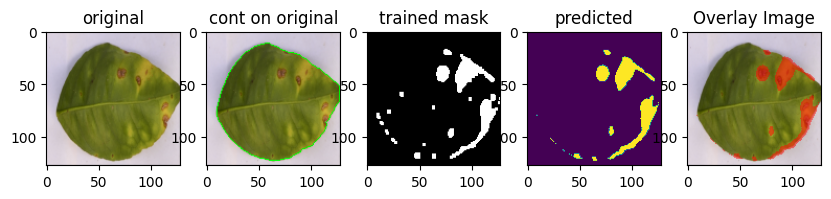

The affected area is 1302 pixels.


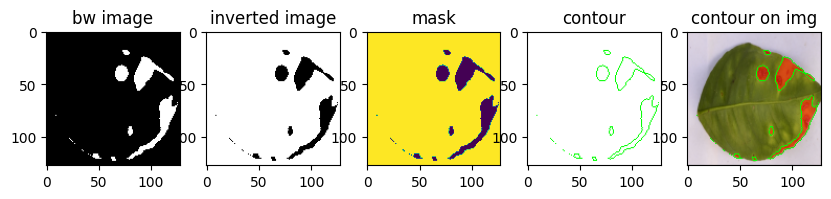

leaf region 2990.5


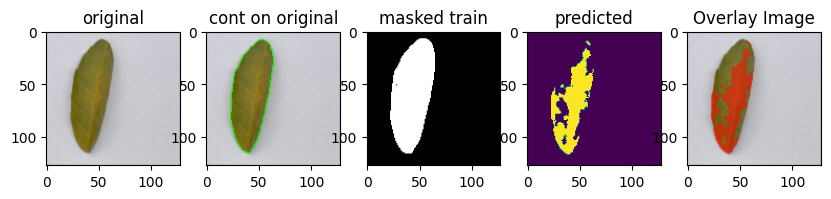

The affected area is 1775 pixels.


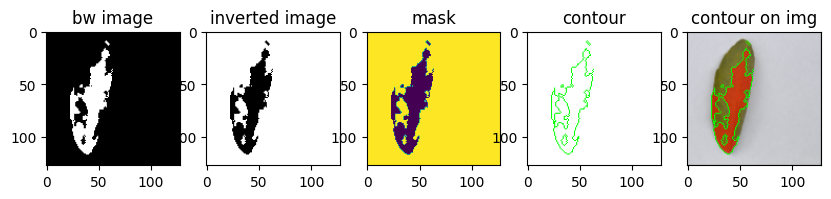

In [ ]:
idx = 7

idx = 5


preds_train = model1.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model1.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model1.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

def overlay_mask_on_image(image, mask, alpha=0.5):
    # Assuming mask is a color image with the same dimensions as the input image
    # and the mask's positive areas are represented by non-black pixels.

    # Create an overlay mask where the mask is not black
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)

    # Create an RGB version of the binary overlay mask
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    # Overlay the mask on the image
    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image

# Perform a sanity check on some random training samples111111
ix = random.randint(0, len(preds_train_t))
selected_image = X_train[ix]
im1 = selected_image
ground_truth_mask = Y_train[ix]
selected_mask = preds_train_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('original')
plt.imshow(selected_image)
# Convert the image to grayscale
gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(im1, contours1, -1, (0, 255, 0), 1)

# Calculate the area of each contour
t_area = 0
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    t_area += area

print(f"The leaf area is {t_area} pixels.")
plt.subplot(1,5,2)
plt.title('cont on original')
plt.imshow(im1)

# imshow(np.squeeze(Y_train[ix]))222222train masked image
# data1 = np.squeeze(Y_train[ix])
plt.subplot(1,5,3)
plt.title('trained mask')
plt.imshow(ground_truth_mask,cmap='gray')  # Add cmap='gray' if the image is grayscale

#33333333333333predection of training set
# data = np.squeeze(preds_train_t[ix])
plt.subplot(1,5,4)
plt.title('predicted')
plt.imshow(selected_mask)

plt.subplot(1, 5, 5)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

# Load the image
image = selected_mask

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')

# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
# total_area = 0
# # Calculate the area of each contour
# for j, contour in enumerate(contours):
#     area1 = cv2.contourArea(contour)
#     # print(f"Leaf {j+1} area: {area1} pixels")
#     total_area += area1
# Calculate pixel area of the overlay image
overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()


#Perform a sanity check on some random validation samples4444441111111-----------------------------------------------------------
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
selected_image = X_train[int(X_train.shape[0]*0.9):][ix]
im = selected_image
ground_truth_mask = np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
selected_mask = preds_val_t[ix]
overlay_image = overlay_mask_on_image(selected_image, selected_mask)

# ix = random.randint(0, len(preds_val_t))
# x2 = X_train[int(X_train.shape[0]*0.9):][ix]
# x1 = X_train[int(X_train.shape[0]*0.9):][ix]
plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('original')
plt.imshow(selected_image)
# Convert the image to grayscale
gray1 = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(im, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
print(f"leaf region {total_area1}")
plt.subplot(1,5,2)
plt.title('cont on original')
plt.imshow(im)


#555555555555222222222222
# data1 =np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix])
plt.subplot(1,5,3)
plt.title('masked train')
plt.imshow(ground_truth_mask,cmap= 'gray')


# 666666666666333333333333predict of validation set---------------------------
# data = np.squeeze(preds_val_t[ix])

plt.subplot(1,5,4)
plt.title('predicted')
plt.imshow(selected_mask)

plt.subplot(1, 5, 5)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()

# Load the image
image = selected_mask

plt.figure(figsize=(10, 4))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')

# Invert the colors
inverted_img = cv2.bitwise_not(image)
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')


# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)

masked_image2 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)

# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(masked_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image2, contours, -1, (0, 255, 0), 1)


overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The affected area is {overlay_image_area} pixels.")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image2)
# Display all subplots
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, applications, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
# Images are RGB
CHANNELS=3
EPOCHS=15

In [ ]:
!unzip /content/drive/MyDrive/en_cit_aug-20240412T062506Z-001.zip

Archive:  /content/drive/MyDrive/en_cit_aug-20240412T062506Z-001.zip
  inflating: en_cit_aug/blackspot_a/b (75)_rotated_90_1.png  
  inflating: en_cit_aug/blackspot_a/b (166)_rotated_0_1.png  
  inflating: en_cit_aug/blackspot_a/b (85)_rotated_0_0.5.png  
  inflating: en_cit_aug/blackspot_a/b (166)_rotated_90_1.png  
  inflating: en_cit_aug/blackspot_a/b (166)_rotated_0_0.5.png  
  inflating: en_cit_aug/blackspot_a/b (75)_rotated_0_1.png  
  inflating: en_cit_aug/blackspot_a/b (24)_rotated_90_0.5.png  
  inflating: en_cit_aug/blackspot_a/b (234)_rotated_90_1.png  
  inflating: en_cit_aug/blackspot_a/b (24)_reflected_y.png  
  inflating: en_cit_aug/blackspot_a/b (166)_reflected_x.png  
  inflating: en_cit_aug/blackspot_a/b (234)_rotated_0_0.5.png  
  inflating: en_cit_aug/blackspot_a/b (85)_reflected_xy.png  
  inflating: en_cit_aug/blackspot_a/b (24)_reflected_x.png  
  inflating: en_cit_aug/blackspot_a/b (75)_reflected_y.png  
  inflating: en_cit_aug/blackspot_a/b (75)_rotated_90_0.5.

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/en_cit_aug",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4018 files belonging to 4 classes.


In [ ]:
class_names=dataset.class_names
class_names

['blackspot_a', 'canker_a', 'greening_a', 'healthy_a']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[1 2 1 0 0 2 3 0 0 1 1 1 2 2 1 1]


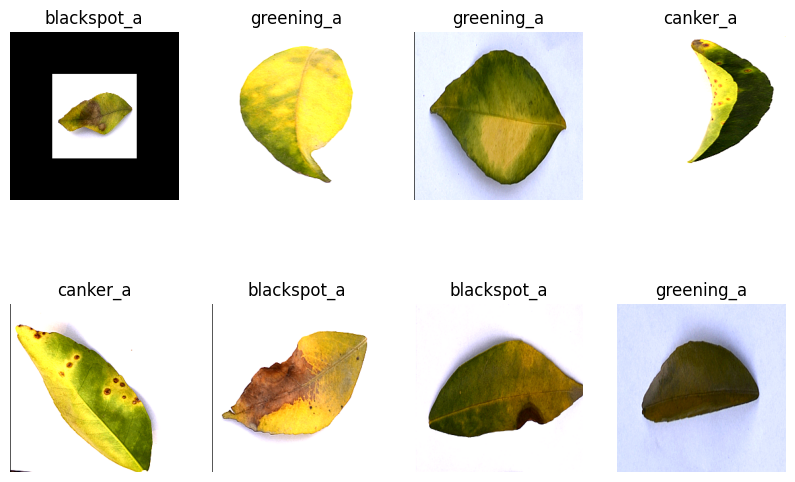

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)


252

In [ ]:
test_ds = dataset.skip(30)
len(test_ds)

222

In [ ]:
val_size=0.1
len(dataset)*val_size

25.200000000000003

In [ ]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [ ]:
test_ds = test_ds.skip(3)
len(test_ds)

219

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

201

In [ ]:
len(val_ds)

25

In [ ]:
len(test_ds)

26

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Define the input shape and number of classes
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

# Use VGG16 as the base model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# Freeze all layers except the last four
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create the improved model
model2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.Dropout(0.5),  # Add Dropout
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower learning rate to fine-tune
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:

# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
201/201 [==============================] - 64s 236ms/step - loss: 0.8928 - accuracy: 0.7014 - val_loss: 1.1929 - val_accuracy: 0.6925 - lr: 1.0000e-04
Epoch 2/30
201/201 [==============================] - 40s 197ms/step - loss: 0.3702 - accuracy: 0.8707 - val_loss: 0.1904 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 3/30
201/201 [==============================] - 39s 193ms/step - loss: 0.2473 - accuracy: 0.9166 - val_loss: 0.1510 - val_accuracy: 0.9475 - lr: 1.0000e-04
Epoch 4/30
201/201 [==============================] - 41s 202ms/step - loss: 0.3011 - accuracy: 0.8960 - val_loss: 1.1999 - val_accuracy: 0.6550 - lr: 1.0000e-04
Epoch 5/30
201/201 [==============================] - 40s 197ms/step - loss: 0.2092 - accuracy: 0.9288 - val_loss: 0.1067 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 6/30
201/201 [==============================] - 39s 195ms/step - loss: 0.1507 - accuracy: 0.9485 - val_loss: 0.1269 - val_accuracy: 0.9550 - lr: 1.0000e-04
Epoch 7/30
201/201 [========

1/1 [==============================] - 0s 33ms/step
              precision    recall  f1-score   support

 blackspot_a       0.97      1.00      0.99        99
    canker_a       1.00      1.00      1.00       130
  greening_a       1.00      0.98      0.99       154
   healthy_a       1.00      1.00      1.00        33

    accuracy                           0.99       416
   macro avg       0.99      1.00      0.99       416
weighted avg       0.99      0.99      0.99       416

              precision    recall  f1-score     support
blackspot_a    0.970588  1.000000  0.985075   99.000000
canker_a       1.000000  1.000000  1.000000  130.000000
greening_a     1.000000  0.980519  0.990164  154.000000
healthy_a      1.000000  1.000000  1.000000   33.000000
accuracy       0.992788  0.992788  0.992788    0.992788
macro avg      0.992647  0.995130  0.993810  416.000000
weighted avg   0.993001  0.992788  0.992807  416.000000


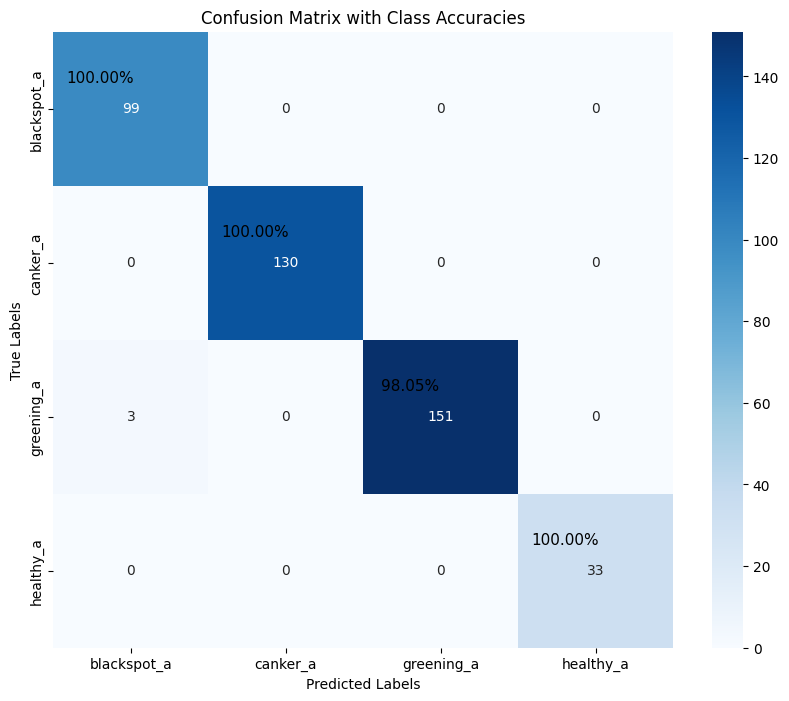

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd
# ... [Your existing code for data loading and model definition] ...

# After training the model, evaluate it on the test dataset
def evaluate_model(model2, test_ds, class_names):
    y_true = []
    y_pred = []

    # Iterate over the test dataset to collect true labels and predictions
    for images, labels in test_ds:
        predictions = model2.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted_classes)
    # Now you have all the true labels and predictions, you can generate the report
    print(classification_report(y_true, y_pred, target_names=class_names))
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # Convert the report to a DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Display the DataFrame as a table
    print(report_df)
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy for each class
    accuracies = cm.diagonal() / cm.sum(axis=1)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Annotate each cell with the accuracy
    for i in range(cm.shape[0]):
        plt.text(i+0.3, i+0.3, f'{accuracies[i]:.2%}',
                 va='center', ha='center', color='black', fontsize=11)

    plt.title('Confusion Matrix with Class Accuracies')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# Call the evaluate_model function after model training
evaluate_model(model2, test_ds, class_names)

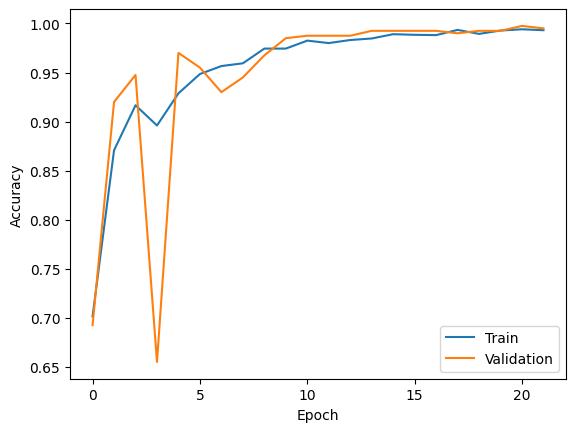

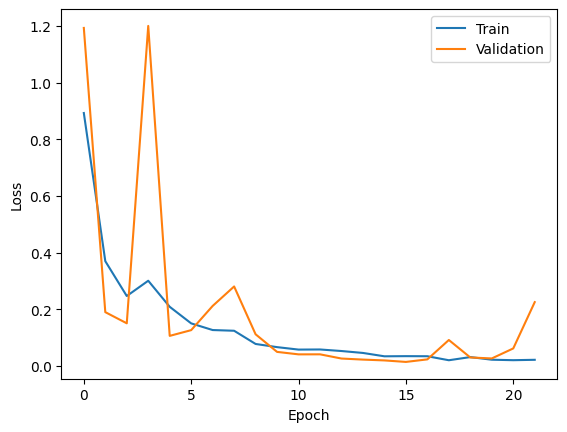

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

first image to predict
actual label: healthy_a
1/1 [==============================] - 1s 563ms/step
predicted label: healthy_a


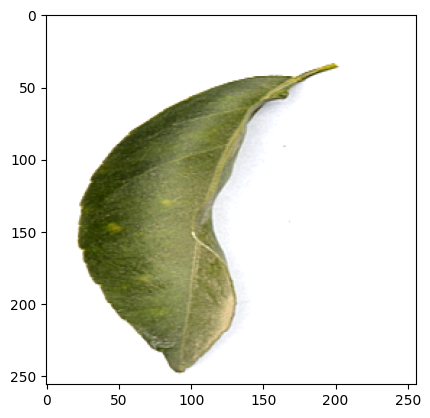

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model2.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model2, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model2.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


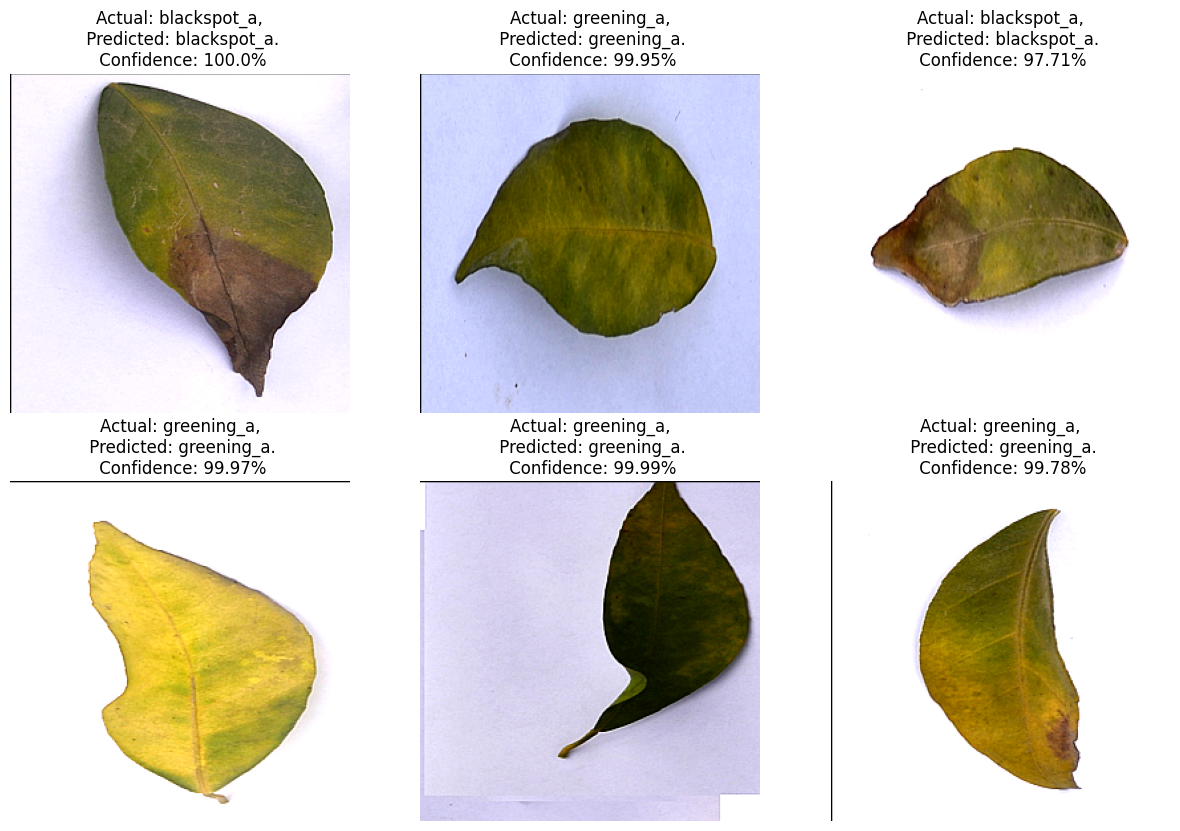

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model2, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 31ms/step
Predicted class: blackspot_a with confidence: 100.0%
1/1 [==============================] - 0s 79ms/step


AttributeError: dtype

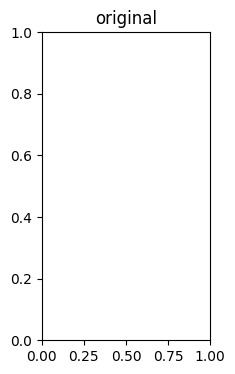

In [ ]:
import os
import numpy as np
import pandas as pd
import random,shutil
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,UpSampling2D
import cv2
from mpl_toolkits.mplot3d import Axes3D

# Load your image
image1 = Image.open('/content/drive/MyDrive/newcit/images/9.png.png')
image = image1
# Preprocess your image (resize if necessary, scale pixel values, etc.)
# image = image.resize((img_height, img_width))  # replace img_height and img_width with the dimensions your model expects
image = np.array(image) / 255.0  # scale pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # model.predict expects a batch of images
# image = image.numpy().astype("uint8")

# predicted_class, confidence = predict(model2, images[i].numpy())
# Use the model to predict the class
predicted_class, confidence = predict(model2, image)

print(f"Predicted class: {predicted_class} with confidence: {confidence}%")


def overlay_mask_on_image(image, mask, alpha=0.5):
    # Assuming mask is a color image with the same dimensions as the input image
    # and the mask's positive areas are represented by non-black pixels.

    # Create an overlay mask where the mask is not black
    overlay_mask = np.any(mask != [0, 0, 0], axis=-1)

    # Create an RGB version of the binary overlay mask
    overlay_rgb = np.zeros_like(image)
    overlay_rgb[overlay_mask] = [255, 0, 0]  # Red color

    # Overlay the mask on the image
    overlay_image = image.copy()
    overlay_image[overlay_mask] = (overlay_image[overlay_mask] * (1 - alpha) + overlay_rgb[overlay_mask] * alpha).astype(np.uint8)

    return overlay_image

selected_image = image1
x1 = selected_image
im = image1
# image1=np.array(image1)
# # Convert your image to numpy array
im = np.array(im)

# Specify the dimensions to which you want to resize your image
IMG_WIDTH = 128
IMG_HEIGHT = 128

# Resize your image
img_resized = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH))

# Now img_resized contains your resized image


# Preprocess your image to match the format expected by your model
# preprocessed_image = preprocess_image(new_image)

# Use your model to predict the segmentation of the image
preds_new = model1.predict(np.expand_dims(img_resized, axis=0), verbose=1)

# Convert the predictions into binary format
preds_new_t = (preds_new > 0.5).astype(np.uint8)

# Display the original image and the segmented image
plt.figure(figsize=(10, 4))
plt.subplot(1,4,1)
plt.title('original')
imshow(selected_image)
# plt.show()
# Convert the image to grayscale
gray1 = cv2.cvtColor(x1, cv2.COLOR_BGR2GRAY)

# Apply a threshold to the image to obtain a binary image
_, thresh1 = cv2.threshold(gray1, 0, 150, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours in the binary image
contours1, _ = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
cv2.drawContours(x1, contours1, -1, (0, 255, 0), 1)
total_area1 = 0
# Calculate the area of each contour
for i, contour1 in enumerate(contours1):
    area = cv2.contourArea(contour1)
    # print(f"Leaf {i+1} area: {area} pixels")
    total_area1 += area
# Display the image
#cv2.imshow('Image', img)
#
print(f"The total area is {total_area1} pixels.")
plt.subplot(1,4,2)
plt.title('cont on original')
plt.imshow(x1)
# plt.show()
# imshow(np.squeeze(preds_new_t[0]))
# plt.show()

selected_mask = np.squeeze(preds_new_t[0])
plt.subplot(1,4,3)
plt.title('prediction')
plt.imshow(selected_mask)

overlay_image = overlay_mask_on_image(selected_image, selected_mask)

plt.subplot(1,4,4)
plt.imshow(overlay_image)
plt.title('Overlay Image')
plt.show()
plt.show()
# print(data.shape)
# print(data.dtype)
# Load the image
image = data
# Load the image
# image = cv2.imread('/content/bw1.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 5))
plt.subplot(1,5,1)
plt.title('bw image')
plt.imshow(image, cmap='gray')
# print(image.shape)
# print(image.dtype)

# Invert the colors
inverted_img = cv2.bitwise_not(data)
inverted_img = cv2.convertScaleAbs(inverted_img)
# Resize the mask to the same size as the image
inverted_img = cv2.resize(inverted_img, (image1.shape[1], image1.shape[0]))
plt.subplot(1,5,2)
plt.title('inverted image')
plt.imshow(inverted_img,cmap='gray')
# print(inverted_img.shape)
# print(inverted_img.dtype)


# Threshold the image to get the white object
_, mask = cv2.threshold(inverted_img, 127, 255, cv2.THRESH_BINARY)
# Apply the mask to the image
masked_image = cv2.bitwise_and(inverted_img, inverted_img, mask=mask)
# Save the result
cv2.imwrite('masked_image.png', masked_image)
plt.subplot(1,5,3)
plt.title('mask')
plt.imshow(masked_image)
# print(masked_image.shape)
# print(masked_image.dtype)
masked_image1 = cv2.bitwise_and(overlay_image, overlay_image, mask=masked_image)
# Apply a threshold to the image to obtain a binary image
_, thresh = cv2.threshold(inverted_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the grayscale image to RGB
masked_image_rgb = cv2.cvtColor(inverted_img, cv2.COLOR_GRAY2RGB)

# Draw the contours on the original image
cv2.drawContours(masked_image_rgb, contours, -1, (0, 255, 0), 1)
cv2.drawContours(masked_image1, contours, -1, (0, 255, 0), 1)
cv2.putText(masked_image1, f"{predicted_class} ({confidence}%)", (10, 20), cv2.FONT_ITALIC, 0.5, (0, 0, 255), 1)

# total_area = 0
# # Calculate the area of each contour
# for j, contour in enumerate(contours):
#     area1 = cv2.contourArea(contour)
#     # print(f"Leaf {j+1} area: {area1} pixels")
#     total_area += area1
overlay_mask = np.any(selected_mask != [0, 0, 0], axis=-1)
overlay_image_area = np.count_nonzero(overlay_mask)

print(f"The **{predicted_class} **DISEASES AFFECTED area is {overlay_image_area} pixels.")
print(f"The total area is {overlay_image_area} pixels.")
percentage = (overlay_image_area/total_area1)*100
print(f"Percentage of disease affected region {overlay_image_area} is {percentage}% of total leaf area {overlay_image_area}")
healthy = 100 - percentage
print(f"Percentage of healthy region is: {healthy} ")
plt.subplot(1,5,4)
plt.title('contour')
# plt.imshow(cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB))
plt.imshow(masked_image_rgb)
plt.subplot(1,5,5)
plt.title('contour on img')
plt.imshow(masked_image1)
# Display all subplots
plt.show()
imshow(masked_image1)
plt.show()

In [ ]:
import os

# Specify the path to your folder
folder_path = '/content/M_citrusO/original'

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Filter only image files (you can customize this based on your desired extensions)
image_files = [file for file in file_list if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

# Count the number of image files
total_image_files = len(image_files)

print(f"Total image files in the folder: {total_image_files}")

Total image files in the folder: 516
